In [46]:
from groundedPL.codificacion import ToPropositionalLogic
from groundedPL.logic_tester import LogicTester
parser = ToPropositionalLogic()

In [48]:
from itertools import product

triplas = product(range(4), range(4), range(4))

for x, y, n in triplas:
    parser.parse(f'En({x}, {y}, {n})')

In [85]:
from groundedPL.logUtils import LogUtils
from typing import List, Tuple
NUM_FILAS = 4
NUM_COLUMNAS = 4


def barco_h(x: int, y: int, n: int) -> List[List[Tuple[int, int]]]:
    """
    Genera todos los barcos horizontales de tamaño `n` que pasan por (x, y).
    
    Parámetros:
        x, y: Coordenadas de la casilla (0-7)
        n: Tamaño del barco (1-4)
    
    Retorna:
        Lista de barcos, donde cada barco es una lista de tuplas (fila, columna)
    """
    if not (0 <= x < NUM_FILAS and 0 <= y < NUM_COLUMNAS):
        return []
    if not (1 <= n <= 4):
        return []
    barcos = []
    # Rango de posibles posiciones iniciales horizontales
    inicio_min = max(0, x - n + 1)
    inicio_max = x
    
    for inicio_x in range(inicio_min, inicio_max + 1):
        casillas = [(inicio_x + i, y) for i in range(n)]
        # Verificar que todas las casillas estén dentro del tablero
        if all(0 <= cx < NUM_FILAS for cx, _ in casillas):
            barcos.append(casillas)
    
    return barcos


def barco_v(x: int, y: int, n: int) -> List[List[Tuple[int, int]]]:
    """
    Genera todos los barcos verticales de tamaño `n` que pasan por (x, y).
    
    Parámetros:
        x, y: Coordenadas de la casilla (0-7)
        n: Tamaño del barco (1-4)
    
    Retorna:
        Lista de barcos, donde cada barco es una lista de tuplas (fila, columna)
    """
    if not (0 <= x < NUM_FILAS and 0 <= y < NUM_COLUMNAS):
        return []
    if not (1 <= n <= 4):
        return []
    barcos = []
    # Rango de posibles posiciones iniciales verticales
    inicio_min = max(0, y - n + 1)
    inicio_max = y
    
    for inicio_y in range(inicio_min, inicio_max + 1):
        casillas = [(x, inicio_y + j) for j in range(n)]
        # Verificar que todas las casillas estén dentro del tablero
        if all(0 <= cy < NUM_COLUMNAS for _, cy in casillas):
            barcos.append(casillas)
    
    return barcos

# Regla general: Barcos alineados horizontal o verticalmente Y todas las casillas entre inicio y fin de un barco deben estar ocupadas
def regla_general():
    condiciones = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for n in range(1, 5):
                # Generar todas las configuraciones válidas de barcos que pasan por (x,y)
                configuraciones = []
                
                # Barcos horizontales
                for barco in barco_h(x, y, n):
                    # Construir conjunción: todas las casillas del barco + negaciones externas
                    clausulas = []
                    for (u, v) in barco:
                        clausulas.append(parser.to_nltk(f"En({u},{v},{n})"))
                    for r in range(NUM_FILAS):
                        for s in range(NUM_COLUMNAS):
                            if (r, s) not in barco:
                                clausulas.append(parser.to_nltk(f"-En({r},{s},{n})"))
                    configuraciones.append(LogUtils.Ytoria(clausulas))
                
                # Barcos verticales
                for barco in barco_v(x, y, n):
                    clausulas = []
                    for (u, v) in barco:
                        clausulas.append(parser.to_nltk(f"En({u},{v},{n})"))
                    for r in range(NUM_FILAS):
                        for s in range(NUM_COLUMNAS):
                            if (r, s) not in barco:
                                clausulas.append(parser.to_nltk(f"-En({r},{s},{n})"))
                    configuraciones.append(LogUtils.Ytoria(clausulas))
                
                # Construir la implicación manualmente
                if configuraciones:
                    antecedente = parser.to_nltk(f"En({x},{y},{n})")
                    consecuente = LogUtils.Otoria(configuraciones)
                    implicacion = f"({antecedente} -> ({consecuente}))"
                    condiciones.append(parser.to_nltk(implicacion))
                """if configuraciones:
                    atom_en = parser.parse(f"En({x},{y},{n})")
                    atom_destapada = parser.parse(f"Destapada({x},{y})")

                    if I.get(atom_en, False) and I.get(atom_destapada, False):
                        # Ya tenemos la info, entonces simplemente agregamos la disyunción afirmativa
                        condiciones.append(LogUtils.Otoria(configuraciones))
                    else:
                        # Información parcial no disponible aún → usamos implicación
                        antecedente = parser.to_nltk(f"En({x},{y},{n}) & Destapada({x},{y})")
                        consecuente = LogUtils.Otoria(configuraciones)
                        formula = f"{antecedente} -> {consecuente}"
                        condiciones.append(parser.to_nltk(formula))"""
    
    return LogUtils.Ytoria(condiciones)

# Regla 4: No superposición de barcos
def crear_regla_4():
    condiciones = []
    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            for n in range(1, 5):
                negaciones = []
                for m in range(1, 5):
                    if m != n:
                        negaciones.append(parser.to_nltk(f"-En({x},{y},{m})"))
                antecedente = f"En({x},{y},{n})"    
                consecuente = LogUtils.Ytoria(negaciones)
                implicacion = f"({antecedente}) -> ({consecuente})"
                condiciones.append(parser.to_nltk(implicacion))
    return LogUtils.Ytoria(condiciones)



def reglas():
    r = []
    print("Regla 1")
    r.append(regla_general())
    print(regla_general())

    print("Regla 4")
    r.append(crear_regla_4())
    print(crear_regla_4())

    return LogUtils.Ytoria(r)

reglas()



Regla 1
((En(0,0,1) -> ((En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3,1)) | (En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3,1)))) & (En(0,0,2) -> ((En(0,0,2) & En(1,0,2) & -En(0,1,2) & -En(0,2,2) & -En(0,3,2) & -En(1,1,2) & -En(1,2,2) & -En(1,3,2) & -En(2,0,2) & -En(2,1,2) & -En(2,2,2) & -En(2,3,2) & -En(3,0,2) & -En(3,1,2) & -En(3,2,2) & -En(3,3,2)) | (En(0,0,2) & En(0,1,2) & -En(0,2,2) & -En(0,3,2) & -En(1,0,2) & -En(1,1,2) & -En(1,2,2) & -En(1,3,2) & -En(2,0,2) & -En(2,1,2) & -En(2,2,2) & -En(2,3,2) & -En(3,0,2) & -En(3,1,2) & -En(3,2,2) & -En(3,3,2)))) & (En(0,0,3) -> ((En(0,0,3) & En(1,0,3) & En(2,0,3) & -En(0,1,3) & -En(0,2,3) & -En(0,3,3) & -En(1,1,3) & -En(1,2,3) & -En(1,

<AndExpression ((En(0,0,1) -> ((En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3,1)) | (En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3,1)))) & (En(0,0,2) -> ((En(0,0,2) & En(1,0,2) & -En(0,1,2) & -En(0,2,2) & -En(0,3,2) & -En(1,1,2) & -En(1,2,2) & -En(1,3,2) & -En(2,0,2) & -En(2,1,2) & -En(2,2,2) & -En(2,3,2) & -En(3,0,2) & -En(3,1,2) & -En(3,2,2) & -En(3,3,2)) | (En(0,0,2) & En(0,1,2) & -En(0,2,2) & -En(0,3,2) & -En(1,0,2) & -En(1,1,2) & -En(1,2,2) & -En(1,3,2) & -En(2,0,2) & -En(2,1,2) & -En(2,2,2) & -En(2,3,2) & -En(3,0,2) & -En(3,1,2) & -En(3,2,2) & -En(3,3,2)))) & (En(0,0,3) -> ((En(0,0,3) & En(1,0,3) & En(2,0,3) & -En(0,1,3) & -En(0,2,3) & -En(0,3,3) & -En(1,1,3) & -En(1,2,3) &

---

In [86]:
condicion_inicial = LogUtils.Ytoria([parser.to_nltk(parser.leer(letra)) for letra in I.keys()])
condicion_inicial

<AndExpression (En(0,0,1) & En(1,0,2) & En(2,0,3) & En(3,0,4))>

# Visualización de interpretaciones <a class="anchor" id="visual"></a>

([Volver al inicio](#inicio))



In [87]:
I = {
    parser.parse("En(0,0,1)"): True,
    parser.parse("En(1,0,2)"): True,
    parser.parse("En(2,0,3)"): True,
    parser.parse("En(3,0,4)"): True,
}

In [88]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualizar_batalla_naval(I: dict):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-0.5, NUM_COLUMNAS-0.5)
    ax.set_ylim(-0.5, NUM_FILAS-0.5)
    ax.set_xticks(range(NUM_COLUMNAS))
    ax.set_yticks(range(NUM_FILAS))
    ax.grid(True,linewidth=0.0)
    ax.invert_yaxis()

    colores = {
        'destapada': '#2196F3',  
        'tapada': '#000000',     
        'barco': '#4CAF50'      
    }

    for x in range(NUM_FILAS):
        for y in range(NUM_COLUMNAS):
            # Dibujar casilla base
            rect = patches.Rectangle(
                (y-.5, x-0.5), 1, 1,
                facecolor=colores['tapada'],
                edgecolor='black',
                linewidth=0.5
            )
            ax.add_patch(rect)
            
    for letra, value in I.items():
            if value:
                x, y, n = parser.obtener_argumentos(letra)
                x, y, n = int(x), int(y), int(n)
                ax.text(
                    y, x, str(n),
                    ha='center', va='center',
                    color='white', fontsize=12,
                    weight='bold'
                )
                # rect.set_facecolor(colores['barco'])
                rect = patches.Rectangle(
                    (y-.5, x-0.5), 1, 1,
                    facecolor=colores['barco'],
                    edgecolor='black',
                    linewidth=0.5
                )
                ax.add_patch(rect)

    plt.title("Batalla Naval - Modo Parcial")
    plt.show()

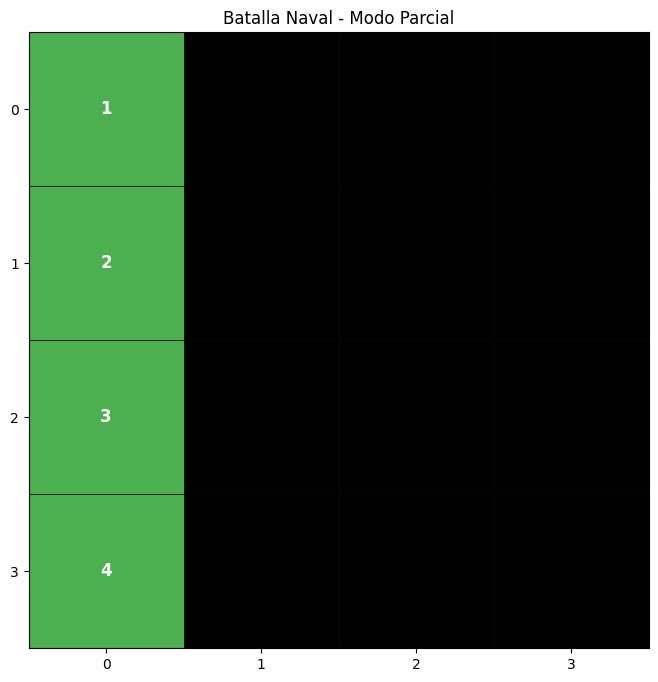

In [89]:
visualizar_batalla_naval(I)

In [90]:

#from groundedPL.tseitin import TseitinTransform
#from groundedPL.codificacion import Modelo

"""regla = reglas()
modelo = Modelo()
modelo.poblar_con(regla)  
formula_logica = modelo.codificar_lp(regla)


tseitin = TseitinTransform()
clausulas = tseitin.tseitin(formula_logica)

resultado, interpretacion = dpll(clausulas, I)
print("Resultado:", resultado)
print("Interpretación encontrada:", interpretacion)"""

"""regla = reglas()
formula_logica = parser.parse(regla)
tseitin = TseitinTransform()
clausulas = tseitin.tseitin(formula_logica)

resultado, interpretacion = dpll(clausulas, I)
print("Resultado:", resultado)
visualizar_batalla_naval(interpretacion)"""


'regla = reglas()\nformula_logica = parser.parse(regla)\ntseitin = TseitinTransform()\nclausulas = tseitin.tseitin(formula_logica)\n\nresultado, interpretacion = dpll(clausulas, I)\nprint("Resultado:", resultado)\nvisualizar_batalla_naval(interpretacion)'

In [91]:
lt = LogicTester()
regla = reglas()
formula_lp = lt.translation_to_prover(regla)
res = lt.SATsolve(formula_lp)

if res == 'UNSAT':
    print('La fórmula es insatisfacible')
else:
    print('La fórmula es satisfacible')
    
    modelo = [lt.to_numeric.literal(x) for x in res]
    modelo = [x for x in modelo if lt.to_numeric.solo_atomo(x) in lt.tseitin.atomos]
    print(f'\nModelo:\n\n\t{modelo}')

    modelo_decodificado = [lt.to_lp.modelo_lp.decodificar(x) for x in modelo]
    print(f'\nModelo decodificado:\n\n\t{modelo_decodificado}')



Regla 1
((En(0,0,1) -> ((En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3,1)) | (En(0,0,1) & -En(0,1,1) & -En(0,2,1) & -En(0,3,1) & -En(1,0,1) & -En(1,1,1) & -En(1,2,1) & -En(1,3,1) & -En(2,0,1) & -En(2,1,1) & -En(2,2,1) & -En(2,3,1) & -En(3,0,1) & -En(3,1,1) & -En(3,2,1) & -En(3,3,1)))) & (En(0,0,2) -> ((En(0,0,2) & En(1,0,2) & -En(0,1,2) & -En(0,2,2) & -En(0,3,2) & -En(1,1,2) & -En(1,2,2) & -En(1,3,2) & -En(2,0,2) & -En(2,1,2) & -En(2,2,2) & -En(2,3,2) & -En(3,0,2) & -En(3,1,2) & -En(3,2,2) & -En(3,3,2)) | (En(0,0,2) & En(0,1,2) & -En(0,2,2) & -En(0,3,2) & -En(1,0,2) & -En(1,1,2) & -En(1,2,2) & -En(1,3,2) & -En(2,0,2) & -En(2,1,2) & -En(2,2,2) & -En(2,3,2) & -En(3,0,2) & -En(3,1,2) & -En(3,2,2) & -En(3,3,2)))) & (En(0,0,3) -> ((En(0,0,3) & En(1,0,3) & En(2,0,3) & -En(0,1,3) & -En(0,2,3) & -En(0,3,3) & -En(1,1,3) & -En(1,2,3) & -En(1,

In [92]:
I = parser.crear_interpretacion(modelo_decodificado)
I

{'ʎ': False,
 'ɝ': True,
 'ʿ': False,
 '˰': False,
 'ɤ': False,
 'ʕ': False,
 'ˆ': False,
 '˷': False,
 'ɫ': False,
 'ʜ': False,
 'ˍ': False,
 '˾': False,
 'ɲ': False,
 'ʣ': False,
 '˔': False,
 '̅': False,
 'δ': False,
 'λ': True,
 'ϥ': False,
 'Ж': False,
 'ч': False,
 'Ϭ': False,
 'Н': False,
 'ю': False,
 'ς': True,
 'ϳ': False,
 'Ф': False,
 'ѕ': False,
 'ω': False,
 'Ϻ': False,
 'Ы': False,
 'ќ': False,
 'ԋ': False,
 'Ԓ': False,
 'ԙ': False,
 'Լ': False,
 'խ': False,
 '֞': False,
 'Ճ': False,
 'մ': False,
 '֥': False,
 'Պ': False,
 'ջ': False,
 '֬': False,
 'Ԡ': False,
 'Ց': False,
 'ւ': False,
 'ֳ': False,
 '٢': False,
 '٩': False,
 'ٰ': False,
 'ٷ': True,
 'ړ': False,
 'ۄ': False,
 '۵': False,
 'ښ': False,
 'ۋ': False,
 'ۼ': False,
 'ڡ': False,
 'ے': False,
 '܃': False,
 'ڨ': True,
 'ۙ': True,
 '܊': True}

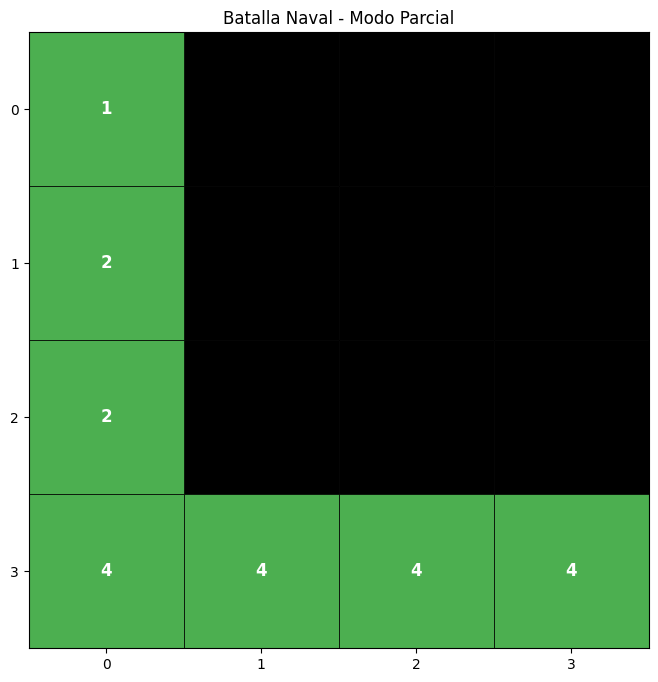

In [93]:
visualizar_batalla_naval(I)